# 02_Figure1_HSC_LSK_scores

- reexport genes enriched in HSCs, LSKs, and control HSC replicate 1 and replicate 2 (before saved only 100 top genes now save all genes)
- calculate scores for HSC and LSK clusters  
- played around with entropy and gini coefficent to determine 'evenness' of score per cell, decided that ultimately this is too complicated to explain (but very cool)
- calculated average scores in clusters to assess similarity between clusters
- some random reprinting of UMAPs for updated paper

Run with this command in docker container

docker run --rm -d --name scanpy -p 8881:8888 -e JUPYTER_ENABLE_LAB=YES -v /Users/efast/Documents/:/home/jovyan/work scanpy:1.7.2

Tukey post hoc reference
https://brownmath.com/stat/anova1.htm

## Loading packages + data

In [1]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from gprofiler import GProfiler
from helper_functions import *
from scipy.stats import entropy

from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)

sc.settings.set_figure_params(dpi=80, dpi_save=300, vector_friendly=True)

## Calculate and export cluster enrichement for HSC replicate 1 and 2 (all genes)

In [2]:
# Replicate 1
adata = sc.read('/home/jovyan/work/Z_TRASH/sc_objects/old_LT_preprocessed.h5ad')
adata.var_names_make_unique()
# make ranked gene list document for LTs
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', n_genes = adata.raw.shape[1])

# make pd dataframe with all genes and save
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
enrichment_clusters = pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores', 'pvals_adj', 'logfoldchanges']})
enrichment_clusters.to_csv('/home/jovyan/work/Z_TRASH/write/all_HSC_repl1_clusters_final_all_genes.csv', index=False, header=True)

# Replicate 2
adata = sc.read('/home/jovyan/work/Z_TRASH/sc_objects/new_ct_LT_preprocessed.h5ad')
adata.var_names_make_unique()

# make ranked gene list document for LTs
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', n_genes = adata.raw.shape[1])

# make pd dataframe with all genes and save
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
enrichment_clusters = pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores', 'pvals_adj', 'logfoldchanges']})
enrichment_clusters.to_csv('/home/jovyan/work/Z_TRASH/write/all_HSC_repl2_clusters_final_all_genes.csv', index=False, header=True)

/opt/conda/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/opt/conda/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)
/opt/conda/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is whe

## Calculate and export cluster enrichment for HSCs

In [3]:
#read adata for LTs
adata = sc.read('/home/jovyan/work/Z_TRASH/sc_objects/LT_preprocessed.h5ad')
adata.var_names_make_unique()

# rename cluster categories
adata.rename_categories('leiden', ['Metabolism', 'Quiescent', 'Activated', 'Interferon', 'Acute-Activation', 'Cell-cycle'])
adata.uns['leiden_colors'] = ['#279e68', '#1f77b4', '#ff7f0e', '#aa40fc', '#d62728', '#8c564b', '#e377c2']

adata

/opt/conda/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/opt/conda/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


AnnData object with n_obs × n_vars = 15355 × 14408
    obs: 'sample', 'n_counts', 'log_counts', 'n_genes', 'percent_mito', 'Female', 'Female_cat', 'Female_str', 'sex_sample', 'batch', 'rXist', 'leiden', 'umap_density_sample'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'diffmap_evals', 'draw_graph', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'sample_colors', 'sex_sample_colors', 'umap', 'umap_density_sample_params'
    obsm: 'X_diffmap', 'X_draw_graph_fr', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [4]:
#read adata for MPPs
adata_m = sc.read('/home/jovyan/work/Z_TRASH/sc_objects/MPP_preprocessed.h5ad')
adata_m.var_names_make_unique()

# rename cluster categories
adata_m.rename_categories('leiden', ['Primed', 'Metabolism', 'Progenitor', 'Cell-cycle', 'Acute-Activation', 
                                   'Interferon', 'Interferon cell-cycle','Myeloid'])
# rename LT with HSC
HSPC_renaming = {'LT': 'HSC'} # dictionary for renaming
adata_m.obs = adata_m.obs.replace(HSPC_renaming)

# reassign colors
adata_m.uns['leiden_colors'] = ['#b5bd61', '#279e68', '#1f77b4','#8c564b', '#d62728',
                              '#aa40fc', '#e377c2',  'tab:cyan']

adata_m.uns['sample_colors'] = ['#A6ACAF', '#2E86C1', '#28B463', '#EC7063', '#884EA0']

adata_m.uns['assignment_colors'] = ['k', 'olivedrab', 'blue',  'firebrick', 'darkgrey' ]

adata_m

AnnData object with n_obs × n_vars = 8191 × 13827
    obs: 'assignment', 'batch', 'counts', 'demux_type', 'hto_type', 'rna_type', 'sample', 'select_cells', 'n_counts', 'log_counts', 'n_genes', 'percent_mito', 'Female', 'Female_cat', 'Female_str', 'sex_sample', 'rXist', 'leiden', 'umap_density_sample', 'umap_density_assignment'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'assignment_colors', 'diffmap_evals', 'draw_graph', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'sample_colors', 'sex_sample_colors', 'umap', 'umap_density_assignment_params', 'umap_density_sample_params'
    obsm: 'X_diffmap', 'X_draw_graph_fr', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [5]:
n_topgenes = 100

# make ranked gene list document for LTs
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', n_genes = adata.raw.shape[1])

# make pd dataframe with all genes and save
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
enrichment_clusters = pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores', 'pvals_adj', 'logfoldchanges']})
enrichment_clusters.to_csv('/home/jovyan/work/Z_TRASH/write/all_HSC_clusters_final_all_genes.csv', index=False, header=True)

# create dictionary with HSC gene lists
own_cl = dict()

for cl in adata.obs['leiden'].cat.categories.tolist():
    cluster_df = sc.get.rank_genes_groups_df(adata, group=cl)
    cluster_df = cluster_df[(cluster_df['pvals_adj'] < 0.05) & (cluster_df['logfoldchanges'] > math.log2(1.2))]
    #own_cl[cl] = cluster_df.sort_values(by='scores', ascending=False)['names'][:n_topgenes].tolist()
    own_cl[cl] = cluster_df['names'].squeeze().str.strip().tolist() 
    
# make ranked gene list document for MPPss
sc.tl.rank_genes_groups(adata_m, 'leiden', method='wilcoxon', n_genes = adata_m.raw.shape[1])

# make pd dataframe with all genes and save
result = adata_m.uns['rank_genes_groups']
groups = result['names'].dtype.names
enrichment_clusters = pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores', 'pvals_adj', 'logfoldchanges']})
enrichment_clusters.to_csv('/home/jovyan/work/Z_TRASH/write/all_MPP_clusters_final_all_genes.csv', index=False, header=True)

# create dictionary with MPP gene lists
own_cl_m = dict()

for cl in adata_m.obs['leiden'].cat.categories.tolist():
    cluster_df = sc.get.rank_genes_groups_df(adata_m, group=cl)
    cluster_df = cluster_df[(cluster_df['pvals_adj'] < 0.05) & (cluster_df['logfoldchanges'] > math.log2(1.2))] 
    #own_cl_m[cl] = cluster_df.sort_values(by='scores', ascending=False)['names'][:n_topgenes].tolist()
    own_cl_m[cl] = cluster_df['names'].squeeze().str.strip().tolist() 

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:18)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:10)


### Plot scores and calculate enrichment

In [6]:
adata.obs['leiden'].cat.categories.tolist()

['Metabolism',
 'Quiescent',
 'Activated',
 'Interferon',
 'Acute-Activation',
 'Cell-cycle']

In [7]:
adata_m.obs['leiden'].cat.categories.tolist()

['Primed',
 'Metabolism',
 'Progenitor',
 'Cell-cycle',
 'Acute-Activation',
 'Interferon',
 'Interferon cell-cycle',
 'Myeloid']

In [8]:
HSC_clusters = ['Metabolism_HSC',
                 'Quiescent_HSC',
                 'Activated_HSC',
                 'Interferon_HSC',
                 'Acute-Activation_HSC',
                 'Cell-cycle_HSC']

LSK_clusters = ['Primed_LSK',
                 'Metabolism_LSK',
                 'Progenitor_LSK',
                 'Cell-cycle_LSK',
                 'Acute-Activation_LSK',
                 'Interferon_LSK',
                 'Interferon cell-cycle_LSK',
                 'Myeloid_LSK']

In [9]:
# calculate scores for HSC in HSC

for i in range(len(HSC_clusters)):
    sc.tl.score_genes(adata, own_cl[adata.obs['leiden'].cat.categories.tolist()[i]], score_name = HSC_clusters[i])
    
# calculate scores for MPP in HSC

for i in range(len(LSK_clusters)):
    sc.tl.score_genes(adata, own_cl_m[adata_m.obs['leiden'].cat.categories.tolist()[i]], score_name = LSK_clusters[i])

# calculate scores for MPP in MPP
for i in range(len(LSK_clusters)):
    sc.tl.score_genes(adata_m, own_cl_m[adata_m.obs['leiden'].cat.categories.tolist()[i]], score_name = LSK_clusters[i])

# calculate scores for HSC in MPP
for i in range(len(HSC_clusters)):
    sc.tl.score_genes(adata_m, own_cl[adata.obs['leiden'].cat.categories.tolist()[i]], score_name = HSC_clusters[i])

computing score 'Metabolism_HSC'
    finished: added
    'Metabolism_HSC', score of gene set (adata.obs).
    753 total control genes are used. (0:00:00)
computing score 'Quiescent_HSC'
    finished: added
    'Quiescent_HSC', score of gene set (adata.obs).
    876 total control genes are used. (0:00:00)
computing score 'Activated_HSC'
    finished: added
    'Activated_HSC', score of gene set (adata.obs).
    875 total control genes are used. (0:00:00)
computing score 'Interferon_HSC'
    finished: added
    'Interferon_HSC', score of gene set (adata.obs).
    1071 total control genes are used. (0:00:00)
computing score 'Acute-Activation_HSC'
    finished: added
    'Acute-Activation_HSC', score of gene set (adata.obs).
    919 total control genes are used. (0:00:00)
computing score 'Cell-cycle_HSC'
    finished: added
    'Cell-cycle_HSC', score of gene set (adata.obs).
    912 total control genes are used. (0:00:00)
computing score 'Primed_LSK'
    finished: added
    'Primed_LSK', 

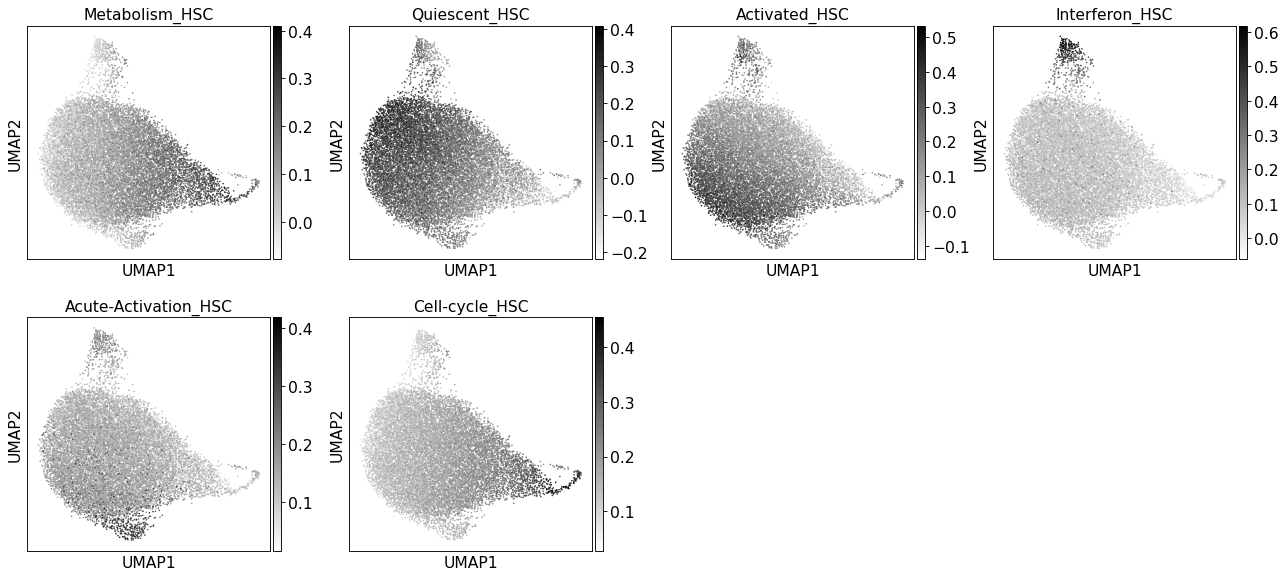

In [10]:
sc.pl.umap(adata, color=HSC_clusters, cmap = 'binary', save='_scoresHSCs_in_HSCs_binary.pdf')

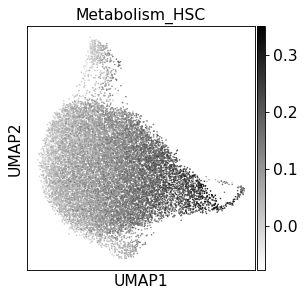

In [11]:
sc.pl.umap(adata, color=HSC_clusters[0], vmax = 0.35, cmap = 'binary', save='_scoresHSCs_Metabolism_bin.pdf')

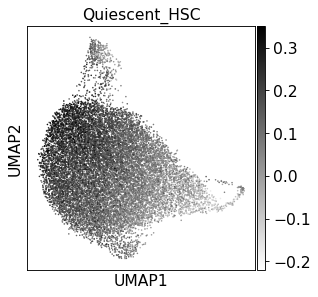

In [12]:
sc.pl.umap(adata, color=HSC_clusters[1], vmax = 0.35, cmap = 'binary', save='_scoresHSCs_Quiescent_bin.pdf')

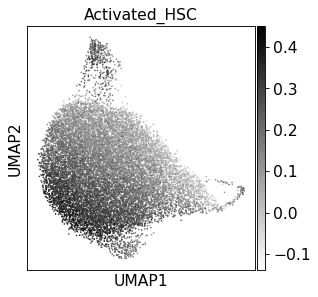

In [13]:
sc.pl.umap(adata, color=HSC_clusters[2], vmax = 0.45, cmap = 'binary', save='_scoresHSCs_Activated_bin.pdf')

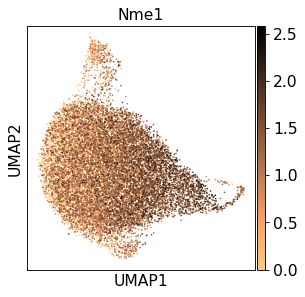

In [14]:
sc.pl.umap(adata, color='Nme1', cmap = 'copper_r', save='_HSCs_Nme1.pdf')

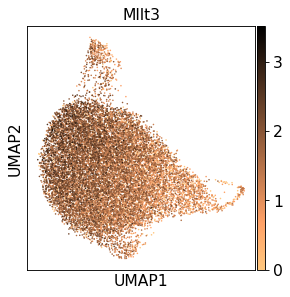

In [15]:
sc.pl.umap(adata, color='Mllt3', cmap = 'copper_r', save='_HSCs_Mllt3.pdf')

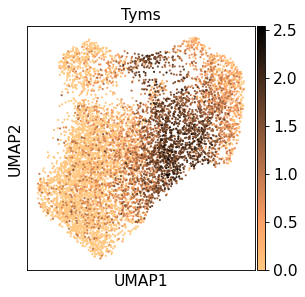

In [16]:
sc.pl.umap(adata_m, color='Tyms', cmap = 'copper_r', save='_LSKs_Tyms.pdf')

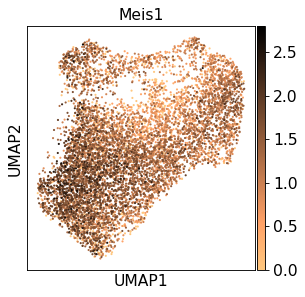

In [17]:
sc.pl.umap(adata_m, color='Meis1', cmap = 'copper_r', save='_LSKs_Meis1.pdf')

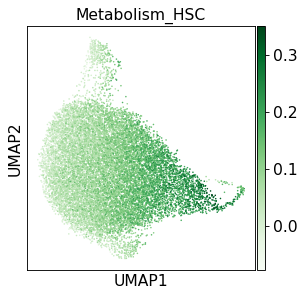

In [18]:
sc.pl.umap(adata, color=HSC_clusters[0], vmax = 0.35, cmap = 'Greens', save='_scoresHSCs_Metabolism.pdf')

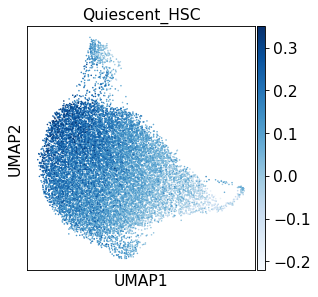

In [19]:
sc.pl.umap(adata, color=HSC_clusters[1], vmax = 0.35, cmap = 'Blues', save='_scoresHSCs_Quiescent.pdf')

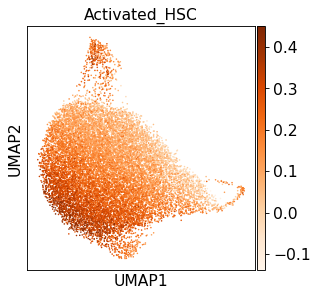

In [20]:
#'Oranges'
hex_list = ['#FEFDFD', '#d46300']
sc.pl.umap(adata, color=HSC_clusters[2], vmax = 0.45, cmap = 'Oranges', save='_scoresHSCs_Activated.pdf')

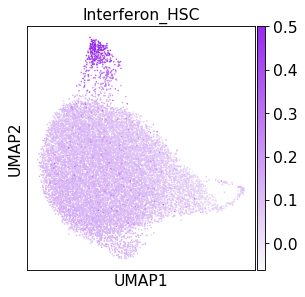

In [21]:
hex_list = ['#FAFAFA', '#9929f0']
sc.pl.umap(adata, color=HSC_clusters[3], vmax = 0.5, cmap = get_continuous_cmap(hex_list), save='_scoresHSCs_Interferon.pdf')

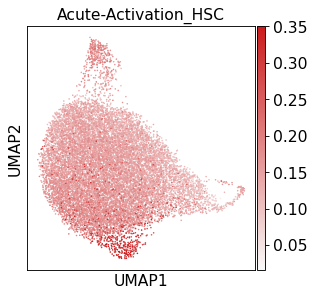

In [22]:
hex_list = ['#FAFAFA', '#cc1b1c']

sc.pl.umap(adata, color=HSC_clusters[4], vmax = 0.35, cmap = get_continuous_cmap(hex_list), save='_scoresHSCs_Acute-activation.pdf')

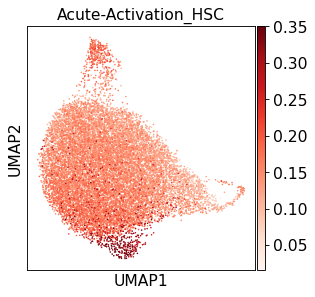

In [23]:
hex_list = ['#FAFAFA', '#cc1b1c']

sc.pl.umap(adata, color=HSC_clusters[4], vmax = 0.35, cmap = 'Reds', save='_scoresHSCs_Acute-activation_Reds.pdf')

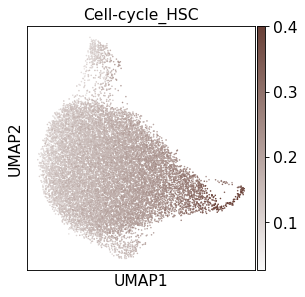

In [24]:
hex_list = ['#FAFAFA', '#694037']
sc.pl.umap(adata, color=HSC_clusters[5], vmax = 0.4, cmap = get_continuous_cmap(hex_list), save='_scoresHSCs_Cell-cycle_brown.pdf')

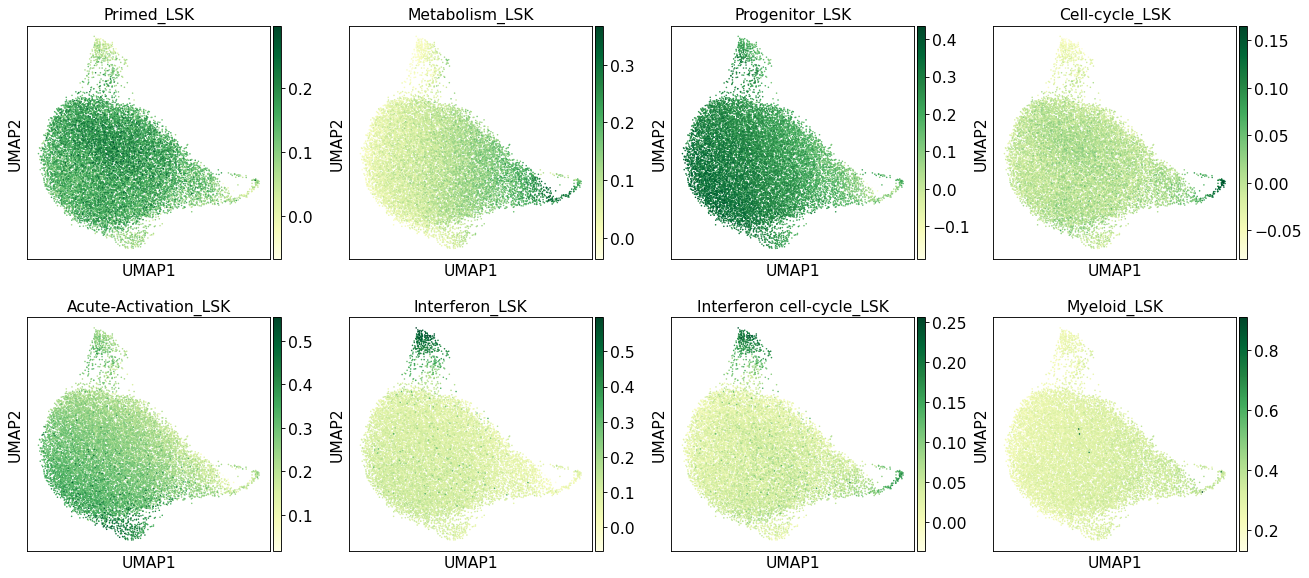

In [25]:
sc.pl.umap(adata, color=LSK_clusters, cmap = 'YlGn', save='_scoresMPPs_in_HSCs.pdf')

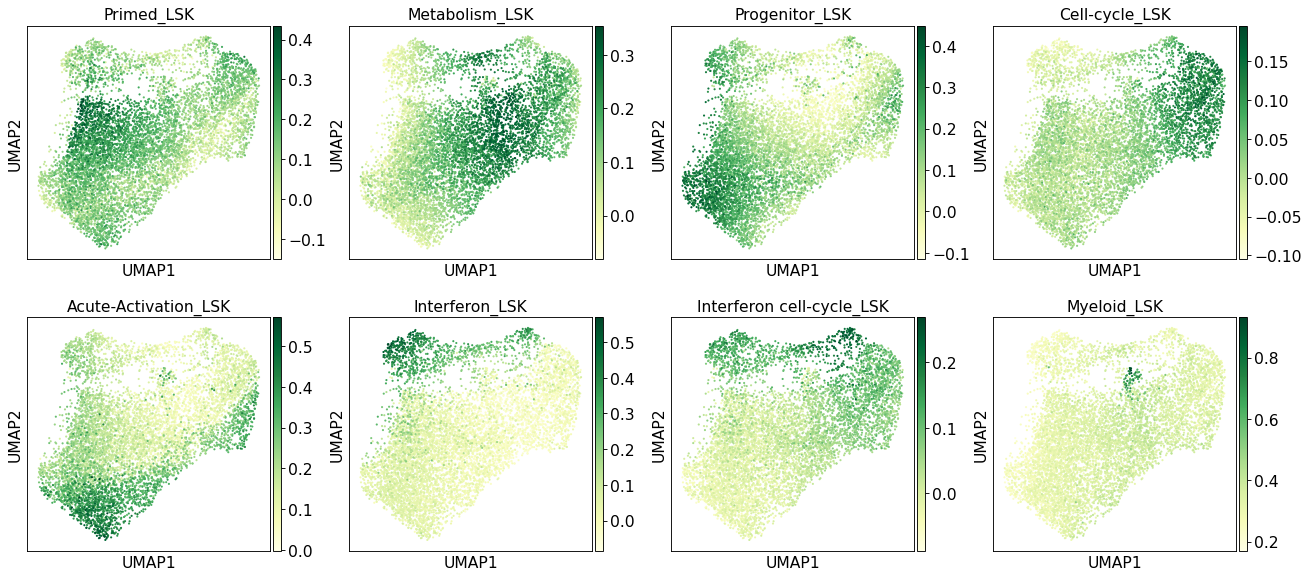

In [26]:
sc.pl.umap(adata_m, color=LSK_clusters, cmap = 'YlGn', save='_scoresMPPs_in_MPPs.pdf')

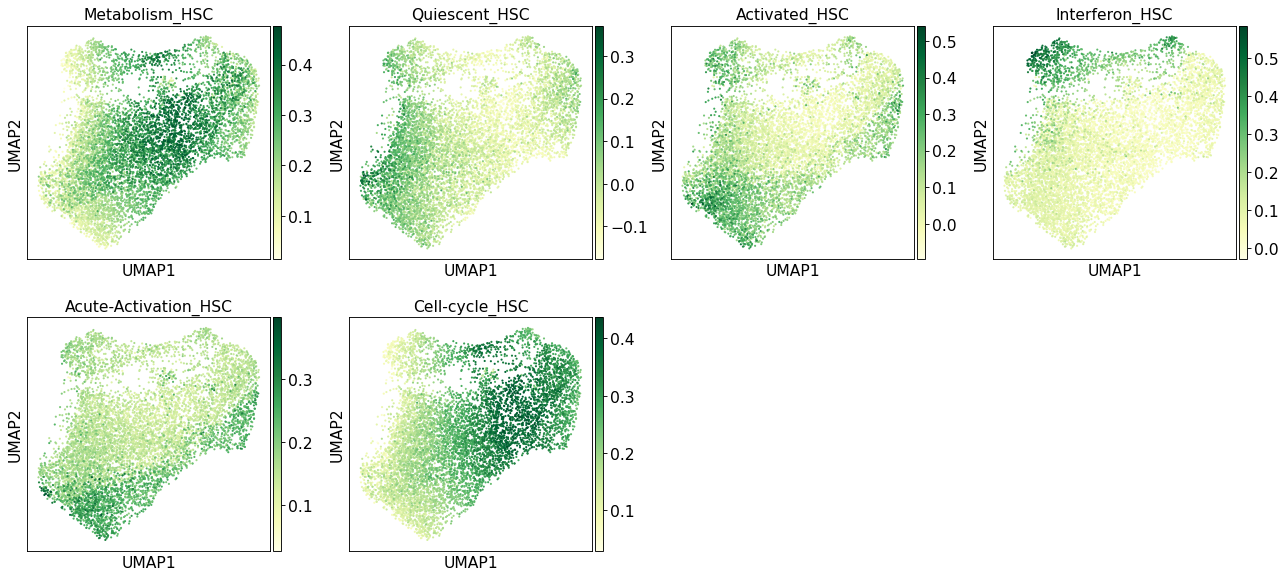

In [27]:
sc.pl.umap(adata_m, color=HSC_clusters, cmap = 'YlGn', save='_scoresMPPs_in_HSCs.pdf')

### Entropy + gini in HSCs

In [28]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = array.flatten()
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

In [29]:
#normalize + negative

#Metabolism and Quiescent
adata.obs['Metabolism_HSC_neg'] = (adata.obs['Metabolism_HSC'] + abs(min(adata.obs['Metabolism_HSC']))) * -1
adata.obs['Metabolism_HSC_neg'] = adata.obs['Metabolism_HSC_neg']/abs(min(adata.obs['Metabolism_HSC_neg']))

adata.obs['Quiescent_HSC_norm'] = adata.obs['Quiescent_HSC'] + abs(min(adata.obs['Quiescent_HSC']))
adata.obs['Quiescent_HSC_norm'] = adata.obs['Quiescent_HSC_norm']/abs(max(adata.obs['Quiescent_HSC_norm']))
adata.obs['combo_Quiescent_Metabolism'] = adata.obs['Quiescent_HSC_norm'] + adata.obs['Metabolism_HSC_neg']

#Metabolism and Activated
adata.obs['Activated_HSC_norm'] = adata.obs['Activated_HSC'] + abs(min(adata.obs['Activated_HSC']))
adata.obs['Activated_HSC_norm'] = adata.obs['Activated_HSC_norm']/abs(max(adata.obs['Activated_HSC_norm']))
adata.obs['combo_Activated_Metabolism'] = adata.obs['Activated_HSC_norm'] + adata.obs['Metabolism_HSC_neg']

#Quiescent and Activated
adata.obs['Activated_HSC_neg'] = (adata.obs['Activated_HSC'] + abs(min(adata.obs['Activated_HSC']))) * -1
adata.obs['Activated_HSC_neg'] = adata.obs['Activated_HSC_neg']/abs(min(adata.obs['Activated_HSC_neg']))
adata.obs['combo_Quiescent_Activated'] = adata.obs['Quiescent_HSC_norm'] + adata.obs['Activated_HSC_neg']

#Metabolism normalized
adata.obs['Metabolism_HSC_norm'] = adata.obs['Metabolism_HSC'] + abs(min(adata.obs['Metabolism_HSC']))
adata.obs['Metabolism_HSC_norm'] = adata.obs['Metabolism_HSC_norm']/abs(max(adata.obs['Metabolism_HSC_norm']))

#Acute-Activation normalize
adata.obs['Acute-Activation_HSC_norm'] = adata.obs['Acute-Activation_HSC'] + abs(min(adata.obs['Acute-Activation_HSC']))
adata.obs['Acute-Activation_HSC_norm'] = adata.obs['Acute-Activation_HSC_norm']/abs(max(adata.obs['Acute-Activation_HSC_norm']))

#Cell-cycle normalized
adata.obs['Cell-cycle_HSC_norm'] = adata.obs['Cell-cycle_HSC'] + abs(min(adata.obs['Cell-cycle_HSC']))
adata.obs['Cell-cycle_HSC_norm'] = adata.obs['Cell-cycle_HSC_norm']/abs(max(adata.obs['Cell-cycle_HSC_norm']))

#Interferon normalized
adata.obs['Interferon_HSC_norm'] = adata.obs['Interferon_HSC'] + abs(min(adata.obs['Interferon_HSC']))
adata.obs['Interferon_HSC_norm'] = adata.obs['Interferon_HSC_norm']/abs(max(adata.obs['Interferon_HSC_norm']))


In [30]:
plt.rcParams['figure.figsize']=(12,12) #rescale figures

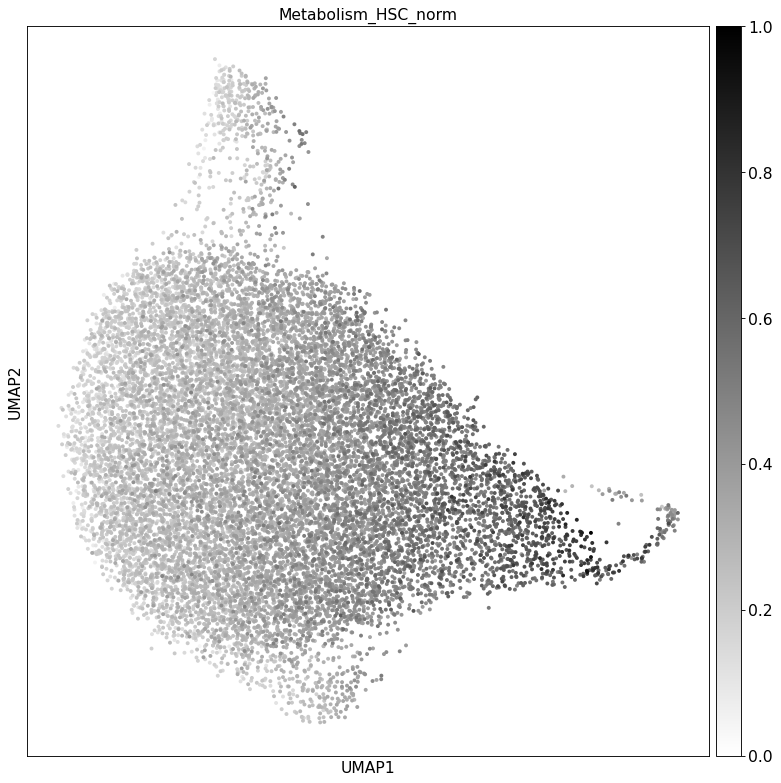

In [37]:
sc.pl.umap(adata, color='Metabolism_HSC_norm', cmap = 'binary', size=50, save='_scoresHSCs_Metabolism_norm_bin.pdf')

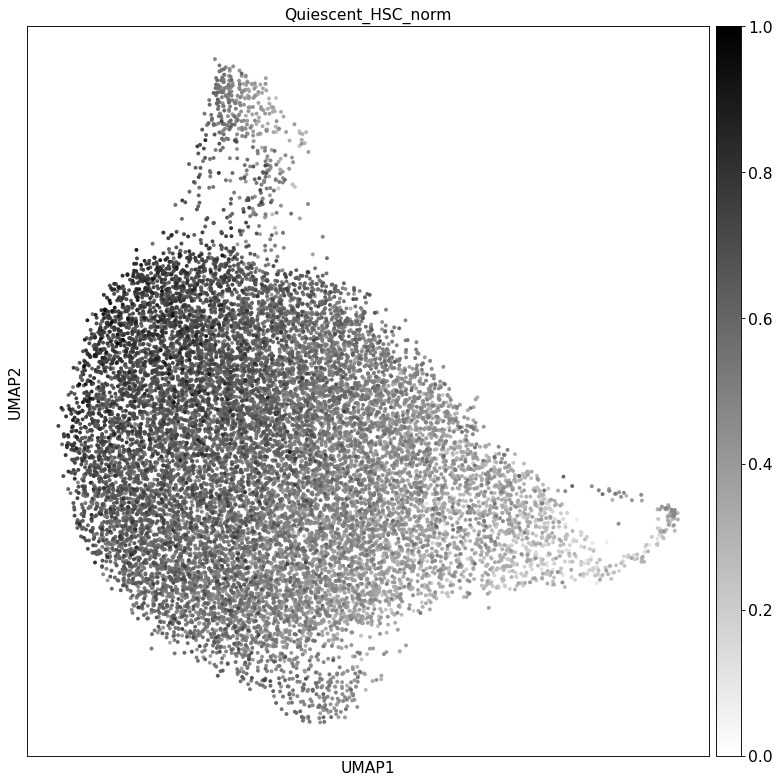

In [38]:
sc.pl.umap(adata, color='Quiescent_HSC_norm', cmap = 'binary', size=50, save='_scoresHSCs_Quiescent_norm_bin.pdf')

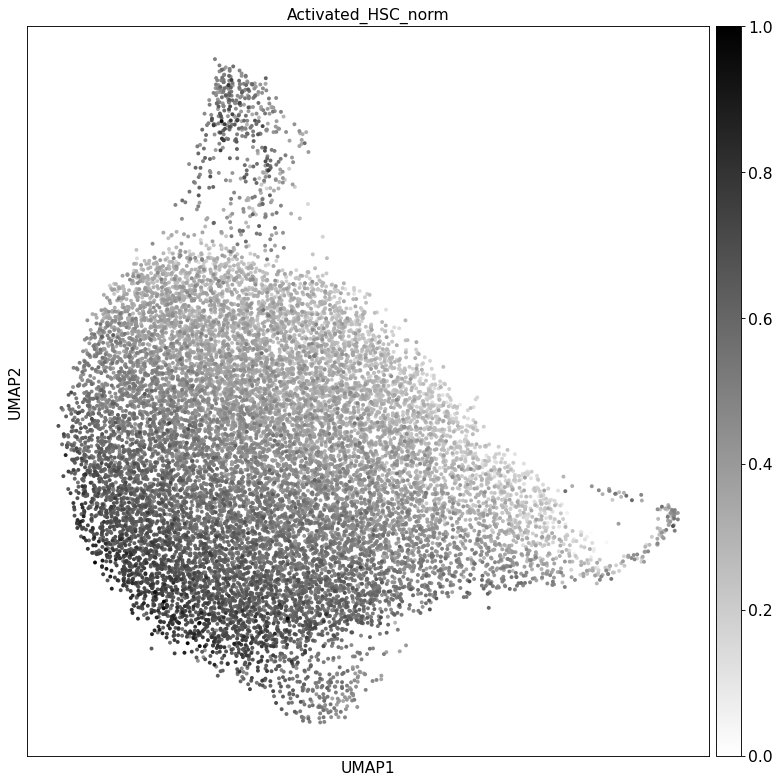

In [39]:
sc.pl.umap(adata, color='Activated_HSC_norm', cmap = 'binary', size=50, save='_scoresHSCs_Activated_norm_bin.pdf')

In [40]:
plt.rcParams['figure.figsize']=(4,4)

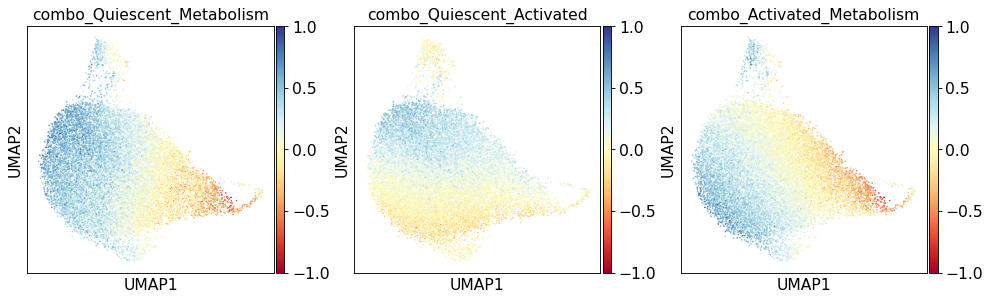

In [41]:
# add together save='_entropy_in_HSCs.pdf'

sc.pl.umap(adata, color=['combo_Quiescent_Metabolism', 'combo_Quiescent_Activated', 'combo_Activated_Metabolism'], 
           vmax=1, vmin=-1, cmap = 'RdYlBu', save='_QMAscorce_HSCs.pdf')

In [42]:
ent_list = []
gini_list = []
for index, row in adata.obs.iterrows():
    ent = 0
    ent_list_temp = [row['Metabolism_HSC_norm'],row['Quiescent_HSC_norm'],row['Activated_HSC_norm'],
                     row['Interferon_HSC_norm'],row['Cell-cycle_HSC_norm'],row['Acute-Activation_HSC_norm']]
    ent = entropy(ent_list_temp)
    ent_list_temp_array = np.array(ent_list_temp)
    ent_list_temp_array = np.around(ent_list_temp_array*100).astype(int)
    gini_a = gini(ent_list_temp_array)
    ent_list.append(ent)
    gini_list.append(gini_a)

adata.obs['entropy_all'] = ent_list
adata.obs['gini_all'] = gini_list

### Entropy + Gini in LSKs

In [43]:
#normalize + negative

for cl in adata_m.obs['leiden'].cat.categories.tolist():
    old_name = cl + '_LSK'
    new_name = cl + '_LSK_norm'
    adata_m.obs[new_name] = adata_m.obs[old_name] + abs(min(adata_m.obs[old_name]))
    adata_m.obs[new_name] = adata_m.obs[new_name]/abs(max(adata_m.obs[new_name]))

In [44]:
adata_m.obs['leiden'].cat.categories.tolist()

['Primed',
 'Metabolism',
 'Progenitor',
 'Cell-cycle',
 'Acute-Activation',
 'Interferon',
 'Interferon cell-cycle',
 'Myeloid']

In [45]:
ent_list = []
gini_list = []
for index, row in adata_m.obs.iterrows():
    ent = 0
    ent_list_temp = [row['Metabolism_LSK_norm'],row['Acute-Activation_LSK_norm'],row['Cell-cycle_LSK_norm'],
                     row['Interferon_LSK_norm'],row['Primed_LSK_norm'],row['Progenitor_LSK_norm'],
                     row['Interferon cell-cycle_LSK_norm'], row['Myeloid_LSK_norm']]
    ent = entropy(ent_list_temp)
    ent_list_temp_array = np.array(ent_list_temp)
    ent_list_temp_array = np.around(ent_list_temp_array*100).astype(int)
    gini_a = gini(ent_list_temp_array)
    ent_list.append(ent)
    gini_list.append(gini_a)

adata_m.obs['entropy_all'] = ent_list
adata_m.obs['gini_all'] = gini_list

### plotting and comparison Gini in LSKs and HSCs

<AxesSubplot:>

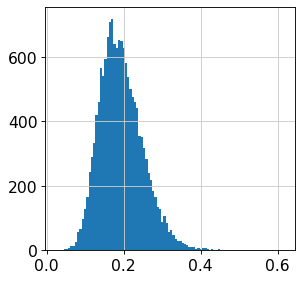

In [46]:
adata.obs['gini_all'].hist(bins=100)

In [47]:
print('maximum gini', adata.obs['gini_all'].max())
print('minimum gini', adata.obs['gini_all'].min())
print('mean gini', adata.obs['gini_all'].mean())
print('stdv gini', adata.obs['gini_all'].std())

maximum gini 0.6151832460732984
minimum gini 0.026246719160104987
mean gini 0.1937555776227309
stdv gini 0.05614963753022003


<AxesSubplot:>

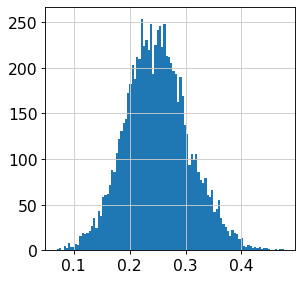

In [48]:
adata_m.obs['gini_all'].hist(bins=100)

In [49]:
print('maximum gini', adata_m.obs['gini_all'].max())
print('minimum gini', adata_m.obs['gini_all'].min())
print('mean gini', adata_m.obs['gini_all'].mean())
print('stdv gini', adata_m.obs['gini_all'].std())

maximum gini 0.4755639097744361
minimum gini 0.06970404984423675
mean gini 0.24932327621686098
stdv gini 0.05716339047470455


In [50]:
# test if means are different in LSKs and HSCs

from scipy import stats

stats.ttest_ind(adata_m.obs['gini_all'], adata.obs['gini_all'])

Ttest_indResult(statistic=71.87458940966245, pvalue=0.0)

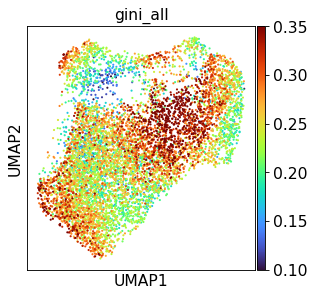

In [51]:
sc.pl.umap(adata_m, color='gini_all', vmax = 0.35, vmin = 0.1, cmap ='turbo', save='_gini_LSKs.pdf')

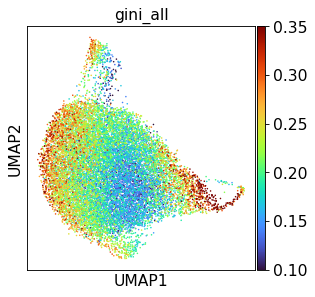

In [52]:
sc.pl.umap(adata, color='gini_all', vmax = 0.35, vmin = 0.1, cmap ='turbo', save='_gini_HSCs.pdf')

### Scores within HSCs

#### Acute-Activation all

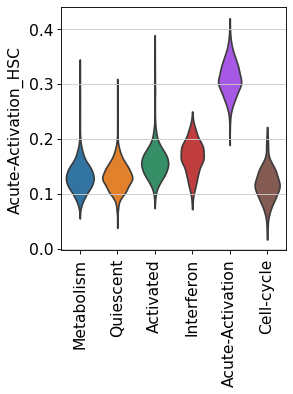

In [53]:
sc.pl.violin(adata,'Acute-Activation_HSC', 
             groupby='leiden', rotation = 90, log=False, stripplot=False, scale='area')

In [54]:
#ANOVA to compare if means are equal between Activated HSCs
score = 'Acute-Activation_HSC'
dic_s = adata.obs.groupby('leiden')[score].apply(list).to_dict()

f_oneway(dic_s['Activated'], dic_s['Acute-Activation'], dic_s['Quiescent'], 
         dic_s['Metabolism'], dic_s['Cell-cycle'], dic_s['Interferon'])

F_onewayResult(statistic=2182.875389091703, pvalue=0.0)

In [55]:
# post hoc Tukey's test Acute Activation score

# perform Tukey's test
tukey = pairwise_tukeyhsd(endog=adata.obs[score],
                          groups=adata.obs['leiden'],
                          alpha=0.05)

#display results
print(tukey)

          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1           group2      meandiff p-adj  lower   upper  reject
-----------------------------------------------------------------------
       Activated Acute-Activation   0.1517 0.001  0.1462  0.1572   True
       Activated       Cell-cycle  -0.0423 0.001  -0.049 -0.0356   True
       Activated       Interferon   0.0075 0.001  0.0032  0.0118   True
       Activated       Metabolism  -0.0265 0.001 -0.0283 -0.0247   True
       Activated        Quiescent  -0.0269 0.001 -0.0287 -0.0251   True
Acute-Activation       Cell-cycle   -0.194 0.001 -0.2025 -0.1855   True
Acute-Activation       Interferon  -0.1442 0.001  -0.151 -0.1375   True
Acute-Activation       Metabolism  -0.1782 0.001 -0.1837 -0.1728   True
Acute-Activation        Quiescent  -0.1787 0.001 -0.1841 -0.1732   True
      Cell-cycle       Interferon   0.0498 0.001   0.042  0.0576   True
      Cell-cycle       Metabolism   0.0158 0.001  0.0091  0.0225

#### Acute-Activation without pIC

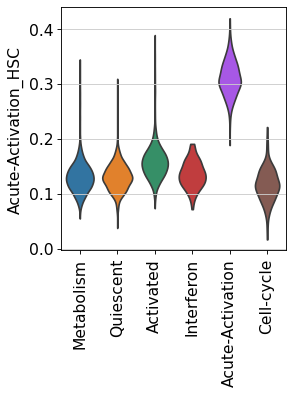

In [56]:
sc.pl.violin(adata[~(adata.obs['sample']=='pIC')],'Acute-Activation_HSC', 
             groupby='leiden', rotation = 90, log=False, stripplot=False, scale='area')

In [57]:
#ANOVA to compare if means are equal between Activated HSCs
score = 'Acute-Activation_HSC'
dic_s = adata.obs[~(adata.obs['sample']=='pIC')].groupby('leiden')[score].apply(list).to_dict()

f_oneway(dic_s['Activated'], dic_s['Acute-Activation'], dic_s['Quiescent'], 
         dic_s['Metabolism'], dic_s['Cell-cycle'], dic_s['Interferon'])

F_onewayResult(statistic=2245.1521868122845, pvalue=0.0)

In [58]:
# post hoc Tukey's test Acute Activation score

# perform Tukey's test
tukey = pairwise_tukeyhsd(endog=adata.obs[~(adata.obs['sample']=='pIC')][score],
                          groups=adata.obs[~(adata.obs['sample']=='pIC')]['leiden'],
                          alpha=0.05)

#display results
print(tukey)

          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
     group1           group2      meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------
       Activated Acute-Activation   0.1521  0.001  0.1467  0.1575   True
       Activated       Cell-cycle  -0.0424  0.001 -0.0491 -0.0358   True
       Activated       Interferon  -0.0234  0.001 -0.0313 -0.0155   True
       Activated       Metabolism  -0.0274  0.001 -0.0292 -0.0257   True
       Activated        Quiescent   -0.028  0.001 -0.0298 -0.0262   True
Acute-Activation       Cell-cycle  -0.1945  0.001 -0.2029 -0.1861   True
Acute-Activation       Interferon  -0.1755  0.001 -0.1849 -0.1661   True
Acute-Activation       Metabolism  -0.1795  0.001 -0.1849 -0.1741   True
Acute-Activation        Quiescent  -0.1801  0.001 -0.1855 -0.1747   True
      Cell-cycle       Interferon   0.0191  0.001  0.0089  0.0292   True
      Cell-cycle       Metabolism    0.015  0.001  

#### Activated all

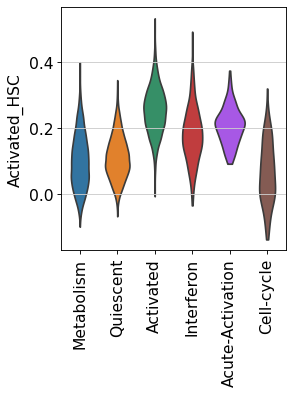

In [59]:
sc.pl.violin(adata,'Activated_HSC', 
             groupby='leiden', rotation = 90, log=False, stripplot=False, scale='area', save='_Activated_score_in_HSCs.pdf')

In [60]:
#ANOVA to compare if means are equal between Activated HSCs
score = 'Activated_HSC'
dic_s = adata.obs.groupby('leiden')[score].apply(list).to_dict()

f_oneway(dic_s['Activated'], dic_s['Acute-Activation'], dic_s['Quiescent'], 
         dic_s['Metabolism'], dic_s['Cell-cycle'], dic_s['Interferon'])

F_onewayResult(statistic=2650.7213330329714, pvalue=0.0)

In [61]:
# post hoc Tukey's test Activation score

# perform Tukey's test
tukey = pairwise_tukeyhsd(endog=adata.obs[score],
                          groups=adata.obs['leiden'],
                          alpha=0.05)

#display results
print(tukey)

          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1           group2      meandiff p-adj  lower   upper  reject
-----------------------------------------------------------------------
       Activated Acute-Activation  -0.0466 0.001 -0.0598 -0.0334   True
       Activated       Cell-cycle  -0.1908 0.001 -0.2071 -0.1746   True
       Activated       Interferon  -0.0751 0.001 -0.0855 -0.0646   True
       Activated       Metabolism  -0.1537 0.001  -0.158 -0.1495   True
       Activated        Quiescent  -0.1426 0.001 -0.1469 -0.1383   True
Acute-Activation       Cell-cycle  -0.1442 0.001 -0.1647 -0.1237   True
Acute-Activation       Interferon  -0.0285 0.001 -0.0448 -0.0122   True
Acute-Activation       Metabolism  -0.1072 0.001 -0.1203  -0.094   True
Acute-Activation        Quiescent   -0.096 0.001 -0.1092 -0.0828   True
      Cell-cycle       Interferon   0.1157 0.001  0.0969  0.1345   True
      Cell-cycle       Metabolism   0.0371 0.001  0.0209  0.0533

#### Activated without pIC

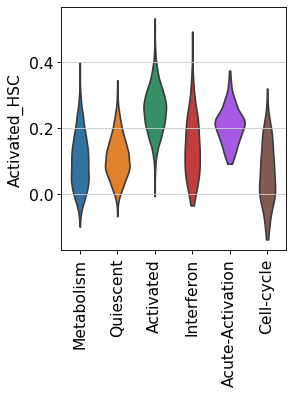

In [62]:
sc.pl.violin(adata[~(adata.obs['sample']=='pIC')],'Activated_HSC', 
             groupby='leiden', rotation = 90, log=False, stripplot=False, scale='area')

In [63]:
#ANOVA to compare if means are equal between Activated HSCs
score = 'Activated_HSC'
dic_s = adata.obs[~(adata.obs['sample']=='pIC')].groupby('leiden')[score].apply(list).to_dict()

f_oneway(dic_s['Activated'], dic_s['Acute-Activation'], dic_s['Quiescent'], 
         dic_s['Metabolism'], dic_s['Cell-cycle'], dic_s['Interferon'])

F_onewayResult(statistic=2608.8014668747524, pvalue=0.0)

In [64]:
# post hoc Tukey's test Activation score

# perform Tukey's test
tukey = pairwise_tukeyhsd(endog=adata.obs[~(adata.obs['sample']=='pIC')][score],
                          groups=adata.obs[~(adata.obs['sample']=='pIC')]['leiden'],
                          alpha=0.05)

#display results
print(tukey)

          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1           group2      meandiff p-adj  lower   upper  reject
-----------------------------------------------------------------------
       Activated Acute-Activation  -0.0466 0.001 -0.0598 -0.0333   True
       Activated       Cell-cycle  -0.1918 0.001 -0.2081 -0.1754   True
       Activated       Interferon  -0.1126 0.001 -0.1319 -0.0932   True
       Activated       Metabolism  -0.1544 0.001 -0.1587 -0.1501   True
       Activated        Quiescent  -0.1435 0.001 -0.1479 -0.1392   True
Acute-Activation       Cell-cycle  -0.1452 0.001 -0.1658 -0.1246   True
Acute-Activation       Interferon   -0.066 0.001  -0.089  -0.043   True
Acute-Activation       Metabolism  -0.1078 0.001  -0.121 -0.0946   True
Acute-Activation        Quiescent   -0.097 0.001 -0.1102 -0.0838   True
      Cell-cycle       Interferon   0.0792 0.001  0.0543  0.1041   True
      Cell-cycle       Metabolism   0.0374 0.001   0.021  0.0537

### Scores within LSKs

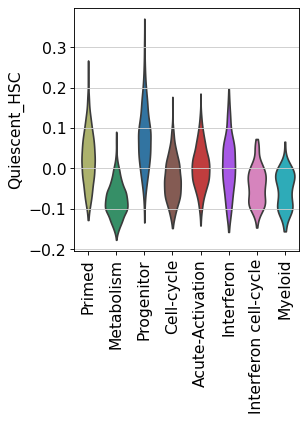

In [65]:
sc.pl.violin(adata_m,'Quiescent_HSC', 
             groupby='leiden', rotation = 90, log=False, stripplot=False, scale='area', save='_HSCQuies_MPPs.pdf')

In [66]:
#ANOVA to compare if means are equal between Activated HSCs
score = 'Quiescent_HSC'
dic_s = adata_m.obs.groupby('leiden')[score].apply(list).to_dict()

f_oneway(dic_s['Primed'], dic_s['Acute-Activation'], dic_s['Progenitor'], 
         dic_s['Metabolism'], dic_s['Cell-cycle'], dic_s['Interferon'], dic_s['Interferon cell-cycle'],
         dic_s['Myeloid'])

F_onewayResult(statistic=805.5463388199988, pvalue=0.0)

In [67]:
# post hoc Tukey's test Acute Activation score

# perform Tukey's test
tukey = pairwise_tukeyhsd(endog=adata_m.obs[score],
                          groups=adata_m.obs['leiden'],
                          alpha=0.05)

#display results
print(tukey)

               Multiple Comparison of Means - Tukey HSD, FWER=0.05                
        group1                group2        meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------------
     Acute-Activation            Cell-cycle  -0.0302  0.001 -0.0378 -0.0226   True
     Acute-Activation            Interferon   0.0021    0.9 -0.0066  0.0108  False
     Acute-Activation Interferon cell-cycle   -0.045  0.001 -0.0591 -0.0309   True
     Acute-Activation            Metabolism  -0.0798  0.001 -0.0868 -0.0727   True
     Acute-Activation               Myeloid  -0.0557  0.001 -0.0775 -0.0339   True
     Acute-Activation                Primed   0.0211  0.001  0.0141  0.0282   True
     Acute-Activation            Progenitor   0.0712  0.001  0.0639  0.0785   True
           Cell-cycle            Interferon   0.0322  0.001  0.0237  0.0408   True
           Cell-cycle Interferon cell-cycle  -0.0148 0.0283 -0.0288 -0.0009   True
    

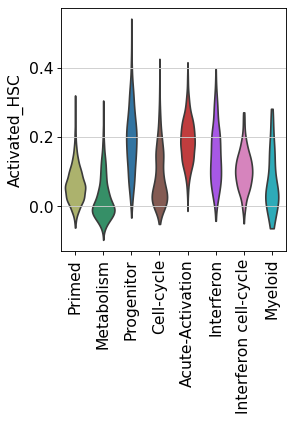

In [68]:
sc.pl.violin(adata_m,'Activated_HSC', 
             groupby='leiden', rotation = 90, log=False, stripplot=False, scale='area', save='_HSCActivated_MPPs.pdf')

In [69]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

#ANOVA to compare if means are equal between Activated HSCs
score = 'Activated_HSC'
dic_s = adata_m.obs.groupby('leiden')[score].apply(list).to_dict()

f_oneway(dic_s['Primed'], dic_s['Acute-Activation'], dic_s['Progenitor'], 
         dic_s['Metabolism'], dic_s['Cell-cycle'], dic_s['Interferon'], dic_s['Interferon cell-cycle'],
         dic_s['Myeloid'])

F_onewayResult(statistic=934.5413515018826, pvalue=0.0)

In [70]:
# post hoc Tukey's test Activation score

# perform Tukey's test
tukey = pairwise_tukeyhsd(endog=adata_m.obs[score],
                          groups=adata_m.obs['leiden'],
                          alpha=0.05)

#display results
print(tukey)

               Multiple Comparison of Means - Tukey HSD, FWER=0.05                
        group1                group2        meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------------
     Acute-Activation            Cell-cycle  -0.1028  0.001 -0.1119 -0.0937   True
     Acute-Activation            Interferon  -0.0426  0.001  -0.053 -0.0321   True
     Acute-Activation Interferon cell-cycle  -0.0842  0.001 -0.1011 -0.0673   True
     Acute-Activation            Metabolism  -0.1649  0.001 -0.1734 -0.1564   True
     Acute-Activation               Myeloid  -0.1189  0.001  -0.145 -0.0928   True
     Acute-Activation                Primed  -0.1263  0.001 -0.1348 -0.1179   True
     Acute-Activation            Progenitor   0.0008    0.9  -0.008  0.0096  False
           Cell-cycle            Interferon   0.0602  0.001    0.05  0.0705   True
           Cell-cycle Interferon cell-cycle   0.0186 0.0179  0.0018  0.0354   True
    

In [71]:
df = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
df

group1                 group2  meandiff   p-adj   lower  \
0        Acute-Activation             Cell-cycle   -0.1028  0.0010 -0.1119   
1        Acute-Activation             Interferon   -0.0426  0.0010 -0.0530   
2        Acute-Activation  Interferon cell-cycle   -0.0842  0.0010 -0.1011   
3        Acute-Activation             Metabolism   -0.1649  0.0010 -0.1734   
4        Acute-Activation                Myeloid   -0.1189  0.0010 -0.1450   
5        Acute-Activation                 Primed   -0.1263  0.0010 -0.1348   
6        Acute-Activation             Progenitor    0.0008  0.9000 -0.0080   
7              Cell-cycle             Interferon    0.0602  0.0010  0.0500   
8              Cell-cycle  Interferon cell-cycle    0.0186  0.0179  0.0018   
9              Cell-cycle             Metabolism   -0.0621  0.0010 -0.0703   
10             Cell-cycle                Myeloid   -0.0161  0.5609 -0.0421   
11             Cell-cycle                 Primed   -0.0235  0.0010 -0.0317   
12             Cell-cycle             Progenitor    0.1036  0.0010  0.0951   
13             Interferon  Interferon cell-cycle   -0.0416  0.0010 -0.0592   
14             Interferon             Metabolism   -0.1223  0.0010 -0.1320   
15             Interferon                Myeloid   -0.0763  0.0010 -0.1028   
16             Interferon                 Primed   -0.0837  0.0010 -0.0934   
17             Interferon             Progenitor    0.0434  0.0010  0.0334   
18  Interferon cell-cycle             Metabolism   -0.0807  0.0010 -0.0971   
19  Interferon cell-cycle                Myeloid   -0.0347  0.0096 -0.0643   
20  Interferon cell-cycle                 Primed   -0.0421  0.0010 -0.0585   
21  Interferon cell-cycle             Progenitor    0.0850  0.0010  0.0684   
22             Metabolism                Myeloid    0.0460  0.0010  0.0202   
23             Metabolism                 Primed    0.0386  0.0010  0.0311   
24             Metabolism             Progenitor    0.1657  0.0010  0.1579   
25                Myeloid                 Primed   -0.0074  0.9000 -0.0333   
26                Myeloid             Progenitor    0.1197  0.0010  0.0938   
27                 Primed             Progenitor    0.1271  0.0010  0.1193   

     upper  reject  
0  -0.0937    True  
1  -0.0321    True  
2  -0.0673    True  
3  -0.1564    True  
4  -0.0928    True  
5  -0.1179    True  
6   0.0096   False  
7   0.0705    True  
8   0.0354    True  
9  -0.0539    True  
10  0.0100   False  
11 -0.0153    True  
12  0.1121    True  
13 -0.0241    True  
14 -0.1126    True  
15 -0.0498    True  
16 -0.0741    True  
17  0.0533    True  
18 -0.0642    True  
19 -0.0050    True  
20 -0.0257    True  
21  0.1016    True  
22  0.0718    True  
23  0.0460    True  
24  0.1735    True  
25  0.0184   False  
26  0.1456    True  
27  0.1350    True

### printout of means + std for Text

### HSCs

In [72]:
adata.obs.groupby(['leiden'])[HSC_clusters].mean()

Metabolism_HSC  Quiescent_HSC  Activated_HSC  \
leiden                                                           
Metabolism              0.148759       0.036700       0.100597   
Quiescent               0.051484       0.173963       0.111757   
Activated               0.059401       0.112988       0.254339   
Interferon              0.042141       0.088101       0.179257   
Acute-Activation        0.059271       0.082341       0.207757   
Cell-cycle              0.207212      -0.053321       0.063532   

                  Interferon_HSC  Acute-Activation_HSC  Cell-cycle_HSC  
leiden                                                                  
Metabolism              0.072672              0.132414        0.202202  
Quiescent               0.086531              0.131980        0.135322  
Activated               0.101847              0.158904        0.145623  
Interferon              0.384121              0.166414        0.128207  
Acute-Activation        0.109876              0.310632        0.148065  
Cell-cycle              0.046157              0.116600        0.359317

In [73]:
adata.obs.groupby(['leiden'])[HSC_clusters].std()

Metabolism_HSC  Quiescent_HSC  Activated_HSC  \
leiden                                                           
Metabolism              0.050716       0.065998       0.081423   
Quiescent               0.037986       0.064793       0.065172   
Activated               0.040272       0.064760       0.069949   
Interferon              0.048440       0.070488       0.081748   
Acute-Activation        0.037230       0.056249       0.056005   
Cell-cycle              0.082516       0.077155       0.092017   

                  Interferon_HSC  Acute-Activation_HSC  Cell-cycle_HSC  
leiden                                                                  
Metabolism              0.032787              0.030820        0.040061  
Quiescent               0.030490              0.026243        0.025409  
Activated               0.030490              0.033544        0.026817  
Interferon              0.124999              0.030572        0.032767  
Acute-Activation        0.025002              0.031788        0.023491  
Cell-cycle              0.037142              0.030248        0.053907

In [74]:
adata.obs.groupby(['leiden'])[LSK_clusters].mean()

Primed_LSK  Metabolism_LSK  Progenitor_LSK  Cell-cycle_LSK  \
leiden                                                                         
Metabolism          0.140602        0.129095        0.186913       -0.002909   
Quiescent           0.157461        0.057672        0.246766       -0.004240   
Activated           0.138394        0.060880        0.280610       -0.005619   
Interferon          0.078741        0.034008        0.212153       -0.034448   
Acute-Activation    0.083470        0.068436        0.233273       -0.002908   
Cell-cycle          0.063811        0.225209        0.090040        0.078970   

                  Acute-Activation_LSK  Interferon_LSK  \
leiden                                                   
Metabolism                    0.227984        0.077443   
Quiescent                     0.242132        0.079797   
Activated                     0.302526        0.099981   
Interferon                    0.249795        0.375567   
Acute-Activation              0.405840        0.091585   
Cell-cycle                    0.176471        0.048100   

                  Interferon cell-cycle_LSK  Myeloid_LSK  
leiden                                                    
Metabolism                         0.034755     0.313306  
Quiescent                          0.022019     0.270200  
Activated                          0.031172     0.282209  
Interferon                         0.139934     0.265341  
Acute-Activation                   0.029003     0.306764  
Cell-cycle                         0.110884     0.371520

In [75]:
adata.obs.groupby(['leiden'])[LSK_clusters].std()

Primed_LSK  Metabolism_LSK  Progenitor_LSK  Cell-cycle_LSK  \
leiden                                                                         
Metabolism          0.038092        0.041969        0.053488        0.016520   
Quiescent           0.034859        0.028123        0.046994        0.015860   
Activated           0.035197        0.028903        0.047037        0.016384   
Interferon          0.046593        0.037468        0.051706        0.018578   
Acute-Activation    0.030438        0.026072        0.042871        0.014797   
Cell-cycle          0.041005        0.071249        0.078565        0.042235   

                  Acute-Activation_LSK  Interferon_LSK  \
leiden                                                   
Metabolism                    0.048051        0.032229   
Quiescent                     0.038736        0.029364   
Activated                     0.042692        0.029258   
Interferon                    0.043906        0.123068   
Acute-Activation              0.044464        0.023087   
Cell-cycle                    0.050160        0.033894   

                  Interferon cell-cycle_LSK  Myeloid_LSK  
leiden                                                    
Metabolism                         0.019882     0.033177  
Quiescent                          0.018175     0.034153  
Activated                          0.018929     0.032019  
Interferon                         0.049898     0.031756  
Acute-Activation                   0.015384     0.029836  
Cell-cycle                         0.036730     0.060141

### LSKs

In [76]:
adata_m.obs.groupby(['leiden'])[HSC_clusters].mean()

Metabolism_HSC  Quiescent_HSC  Activated_HSC  \
leiden                                                                
Primed                       0.226090       0.024769       0.062793   
Metabolism                   0.345036      -0.076141       0.024220   
Progenitor                   0.174599       0.074827       0.189916   
Cell-cycle                   0.246657      -0.026568       0.086301   
Acute-Activation             0.182299       0.003625       0.189115   
Interferon                   0.205932       0.005681       0.146525   
Interferon cell-cycle        0.248558      -0.041409       0.104882   
Myeloid                      0.244972      -0.052059       0.070228   

                       Interferon_HSC  Acute-Activation_HSC  Cell-cycle_HSC  
leiden                                                                       
Primed                       0.080335              0.140510        0.194588  
Metabolism                   0.039278              0.143243        0.337007  
Progenitor                   0.100537              0.176361        0.153546  
Cell-cycle                   0.061881              0.171631        0.311471  
Acute-Activation             0.074190              0.239398        0.178665  
Interferon                   0.328649              0.159643        0.186858  
Interferon cell-cycle        0.278046              0.156324        0.297330  
Myeloid                      0.064360              0.161100        0.265213

In [77]:
adata_m.obs.groupby(['leiden'])[HSC_clusters].std()

Metabolism_HSC  Quiescent_HSC  Activated_HSC  \
leiden                                                                
Primed                       0.076567       0.066699       0.052864   
Metabolism                   0.050017       0.042085       0.060510   
Progenitor                   0.067923       0.076886       0.093332   
Cell-cycle                   0.060959       0.052426       0.080424   
Acute-Activation             0.061809       0.052599       0.065441   
Interferon                   0.093333       0.069370       0.085561   
Interferon cell-cycle        0.059181       0.046299       0.057523   
Myeloid                      0.083482       0.045612       0.085548   

                       Interferon_HSC  Acute-Activation_HSC  Cell-cycle_HSC  
leiden                                                                       
Primed                       0.046484              0.023552        0.050870  
Metabolism                   0.032302              0.036058        0.043479  
Progenitor                   0.049783              0.043364        0.045096  
Cell-cycle                   0.038905              0.045855        0.040504  
Acute-Activation             0.027142              0.033419        0.051738  
Interferon                   0.090908              0.026027        0.085163  
Interferon cell-cycle        0.067872              0.018373        0.043918  
Myeloid                      0.048484              0.044931        0.066117

In [78]:
adata_m.obs.groupby(['leiden'])[LSK_clusters].mean()

Primed_LSK  Metabolism_LSK  Progenitor_LSK  \
leiden                                                              
Primed                   0.225970        0.106377        0.111685   
Metabolism               0.091740        0.244383        0.030939   
Progenitor               0.113110        0.058822        0.257862   
Cell-cycle               0.085744        0.158176        0.066106   
Acute-Activation         0.105394        0.076913        0.160199   
Interferon               0.096992        0.088983        0.125363   
Interferon cell-cycle    0.053529        0.153106        0.039894   
Myeloid                  0.084319        0.153812        0.037148   

                       Cell-cycle_LSK  Acute-Activation_LSK  Interferon_LSK  \
leiden                                                                        
Primed                      -0.003507              0.168005        0.037857   
Metabolism                   0.031406              0.123459       -0.007127   
Progenitor                  -0.014029              0.236798        0.057199   
Cell-cycle                   0.106170              0.173474        0.000320   
Acute-Activation            -0.000787              0.370141        0.028376   
Interferon                  -0.029709              0.176748        0.321273   
Interferon cell-cycle        0.061997              0.125132        0.252685   
Myeloid                      0.019963              0.182224        0.015119   

                       Interferon cell-cycle_LSK  Myeloid_LSK  
leiden                                                         
Primed                                 -0.004641     0.319156  
Metabolism                              0.037687     0.365699  
Progenitor                             -0.019238     0.286257  
Cell-cycle                              0.083702     0.333402  
Acute-Activation                       -0.019588     0.326178  
Interferon                              0.114318     0.300348  
Interferon cell-cycle                   0.196889     0.318493  
Myeloid                                 0.014771     0.657790

In [79]:
adata_m.obs.groupby(['leiden'])[LSK_clusters].std()

Primed_LSK  Metabolism_LSK  Progenitor_LSK  \
leiden                                                              
Primed                   0.069199        0.063741        0.058779   
Metabolism               0.071525        0.043871        0.061970   
Progenitor               0.063095        0.052255        0.062978   
Cell-cycle               0.067698        0.053334        0.066561   
Acute-Activation         0.053745        0.055908        0.065373   
Interferon               0.070985        0.089998        0.090007   
Interferon cell-cycle    0.064223        0.060615        0.067614   
Myeloid                  0.050615        0.074416        0.062115   

                       Cell-cycle_LSK  Acute-Activation_LSK  Interferon_LSK  \
leiden                                                                        
Primed                       0.022933              0.050833        0.048970   
Metabolism                   0.033596              0.069471        0.036852   
Progenitor                   0.021227              0.073898        0.050930   
Cell-cycle                   0.028525              0.095846        0.042176   
Acute-Activation             0.021298              0.063950        0.027370   
Interferon                   0.025739              0.059065        0.094516   
Interferon cell-cycle        0.027309              0.039503        0.075278   
Myeloid                      0.032713              0.098023        0.049234   

                       Interferon cell-cycle_LSK  Myeloid_LSK  
leiden                                                         
Primed                                  0.026565     0.034871  
Metabolism                              0.034886     0.035912  
Progenitor                              0.026978     0.038859  
Cell-cycle                              0.029641     0.037792  
Acute-Activation                        0.021133     0.040752  
Interferon                              0.033848     0.049346  
Interferon cell-cycle                   0.031401     0.035427  
Myeloid                                 0.035095     0.106347

In [80]:
%pip list

Package                       Version
----------------------------- -------------------
alembic                       1.6.0
anndata                       0.7.6
annoy                         1.17.0
anyio                         2.2.0
appdirs                       1.4.4
argon2-cffi                   20.1.0
async-generator               1.10
attrs                         20.3.0
Babel                         2.9.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
beautifulsoup4                4.9.3
bleach                        3.3.0
blinker                       1.4
bokeh                         2.3.1
Bottleneck                    1.3.2
brotlipy                      0.7.0
cached-property               1.5.2
cellbrowser                   0.7.7
certifi                       2020.12.5
certipy                       0.1.3
cffi                          1.14.5
chardet                       4.0.0
click                         7.1.2
cloudpickle                   1.6.0
conda  

In [81]:
sc.logging.print_versions()
pd.show_versions()

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.6
scanpy      1.7.2
sinfo       0.3.4
-----
PIL                 8.1.2
anyio               NA
argon2              20.1.0
attr                20.3.0
babel               2.9.1
backcall            0.2.0
bottleneck          1.3.2
brotli              NA
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.04.1
dateutil            2.8.1
de